In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModel
from deep_macrofin import ActivationType, Comparator, LayerType, OptimizerType, set_seeds, LossReductionMethod
from deep_macrofin.models.multkan import MultKAN

## Model 1
$$\frac{d x}{d t} = 2 * t, x(0)=1$$
Solution: $x(t)=t^2 + 1$

In [2]:
set_seeds(0)
ode1 = PDEModel("ode1", config={"num_epochs": 100, "lr": 1, "loss_log_interval": 10})
ode1.set_state(["t"], {"t": [-2., 2.]})
ode1.add_endog("x", {
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "hidden_units": [1, 2, 1],
    "layer_type": LayerType.MultKAN,
    "activation_type": ActivationType.SiLU,
    "positive": False,
    "derivative_order": 2,
})
ode1.add_endog_equation(r"$\frac{\partial x}{\partial t} = 2 * t$", loss_reduction=LossReductionMethod.SSE)
ode1.add_endog_condition("x", 
                              "x(SV)", {"SV": torch.zeros((1, 1))},
                              Comparator.EQ,
                              "1", {},
                              label="initial_condition")
print(ode1)
if not os.path.exists("./models/multkan/ode1.pt"):
    ode1.train_model("./models/multkan", "ode1.pt", True)
    ode1.eval_model(True)
else:
    ode1.load_model(torch.load("./models/multkan/ode1.pt"))
    ode1.eval_model(True)

=============================Summary of Model ode1==============================
Config: {
 "batch_size": 100,
 "num_epochs": 100,
 "lr": 1,
 "loss_log_interval": 10,
 "optimizer_type": "AdamW",
 "sampling_method": "UniformRandom",
 "loss_balancing": false,
 "bernoulli_prob": 0.9999,
 "loss_balancing_temp": 0.1,
 "loss_balancing_alpha": 0.999,
 "soft_adapt_interval": -1,
 "loss_soft_attention": false
}
Latex Variable Mapping:
{}
User Defined Parameters:
{}

================================State Variables=================================
t: [-2.0, 2.0]

=====================================Agents=====================================

================================Agent Conditions================================

==============================Endogenous Variables==============================
Endogenous Variable Name: x
EndogVar(
  (model): MultKAN(
    (base_fun_name): SiLU()
    (act_fun): ModuleList(
      (0-1): 2 x KANLayer(
        (base_fun): SiLU()
      )
    )
    (base_fun):

D:\UofT\Research\PDE-work\continuous-time-eco-models\deep_macrofin\models\multkan\MultKAN.py:798: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1807.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
D:\UofT\Research\PDE-work\continuous-time-eco-models\deep_macrofin\models\multkan\MultKAN.py:808: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1807.)
  input_range = torch.std(preacts, dim=0) + 0.1
D:\UofT\Research\PDE-work\continuous-time-eco-models\deep_macrofin\models\multkan\MultKAN.py:809: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered in

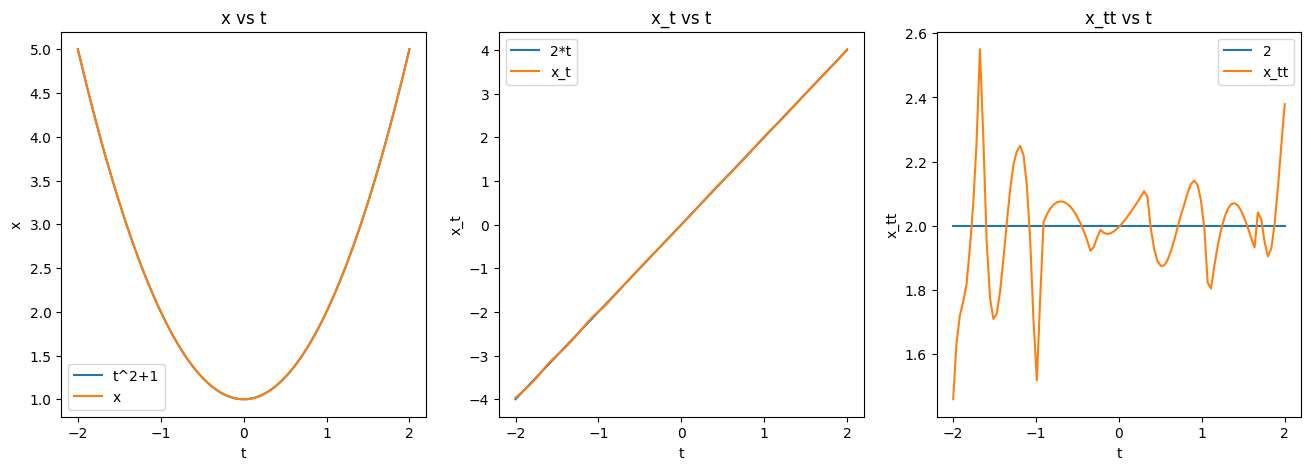

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
t = np.linspace(-2, 2)
ax[0].plot(t, t**2+1, label="t^2+1")
ax[1].plot(t, 2*t, label="2*t")
ax[2].plot(t, np.ones_like(t) * 2, label="2")
ode1.endog_vars["x"].plot("x", {"t": [-2, 2]}, ax=ax[0])
ode1.endog_vars["x"].plot("x_t", {"t": [-2, 2]}, ax=ax[1])
ode1.endog_vars["x"].plot("x_tt", {"t": [-2, 2]}, ax=ax[2])
plt.subplots_adjust()
plt.show()

checkpoint directory created: ./model
saving model version 0.0
====================================Training====================================


Total loss: 0.0005: 100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


training finished, total time :: 39.208086013793945
Best model saved to ./models/multkan/ode1_interpret_best.pt if valid
Model saved to ./models/multkan/ode1_interpret.pt
Model loaded


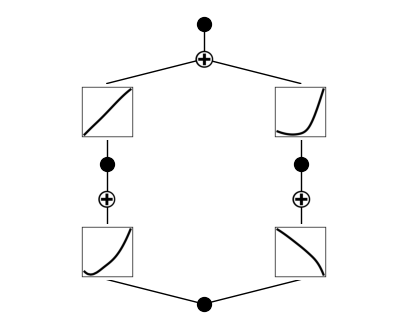

In [4]:
x = ode1.sample(0)
set_seeds(0)
ode1.endog_vars["x"].model = MultKAN([1, 2, 1]).initialize_from_another_model(ode1.endog_vars["x"].model, x)
if not os.path.exists("./models/multkan/ode1_interpret.pt"):
    ode1.train_model("./models/multkan", "ode1_interpret.pt", True)
    ode1.load_model(torch.load("./models/multkan/ode1_interpret_best.pt"))
else:
    ode1.load_model(torch.load("./models/multkan/ode1_interpret_best.pt"))
ode1.endog_vars["x"].model(x)
ode1.endog_vars["x"].model.plot()

In [5]:
ode1.endog_vars["x"].model.auto_symbolic()
formula = ode1.endog_vars["x"].model.symbolic_formula()[0][0]
print("x:", formula)

fixing (0,0,0) with x^2, r2=0.9974040389060974, c=2
fixing (0,0,1) with x^0.5, r2=0.9989480376243591, c=2
fixing (1,0,0) with x, r2=0.999747633934021, c=1
fixing (1,1,0) with 0, r2=0.0, c=0
x: 0.984432629858565*(-0.626400400370642*x_1 - 1)**2 + 0.526610820517742
